In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


## Import raw data

In [29]:
import os
import sys
from google.colab import drive

try:
  drive.mount("/content/drive")
  project_path = "/content/drive/MyDrive/Pytorch pet projects/ML - Projects/ML-Store-Item-Demand-Forecasting-Challenge/data"
except:
  project_path ="../data"

df = raw_train = pd.read_csv(f"{project_path}/train.csv")
test_df = raw_test = pd.read_csv(f"{project_path}/test.csv")
ssub_df = raw_sample_submission = pd.read_csv(f"{project_path}/sample_submission.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Discover data

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [31]:
df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [32]:
df.isnull().sum()

,0
date,0
store,0
item,0
sales,0


## Feature engineering
* Convert `data` to `datetime`

In [33]:
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day
df["day_of_week"] = df["date"].dt.dayofweek
df["is_weekend"] = df["day_of_week"].isin([5,6]).astype(int)

## Visualization

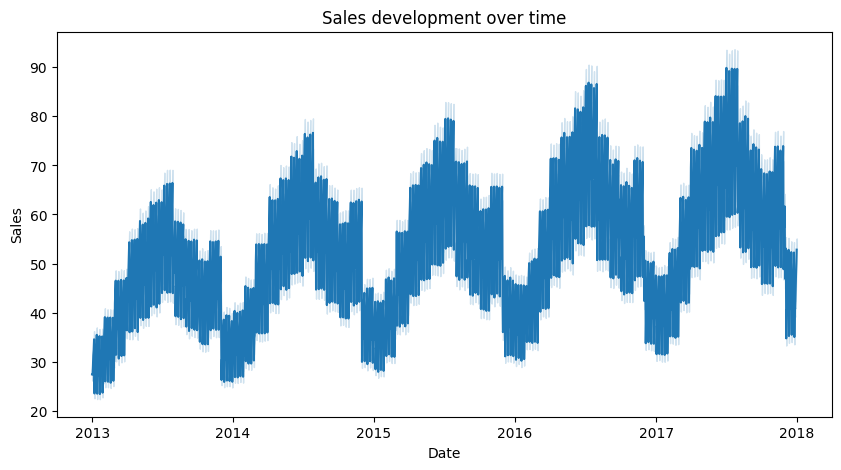

In [34]:
plt.figure(figsize=(10,5))
sns.lineplot(x="date", y="sales", data=df)
plt.title("Sales development over time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

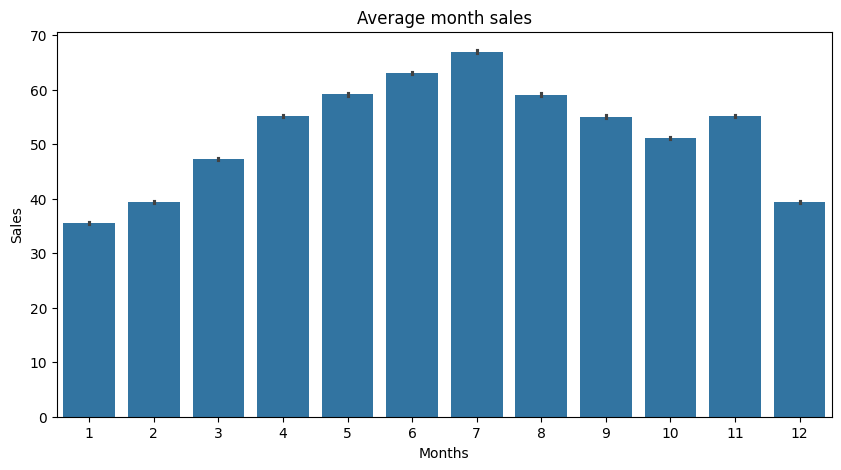

In [35]:
plt.figure(figsize=(10,5))
sns.barplot(x="month", y="sales", data=df)
plt.title("Average month sales")
plt.xlabel("Months")
plt.ylabel("Sales")
plt.show()

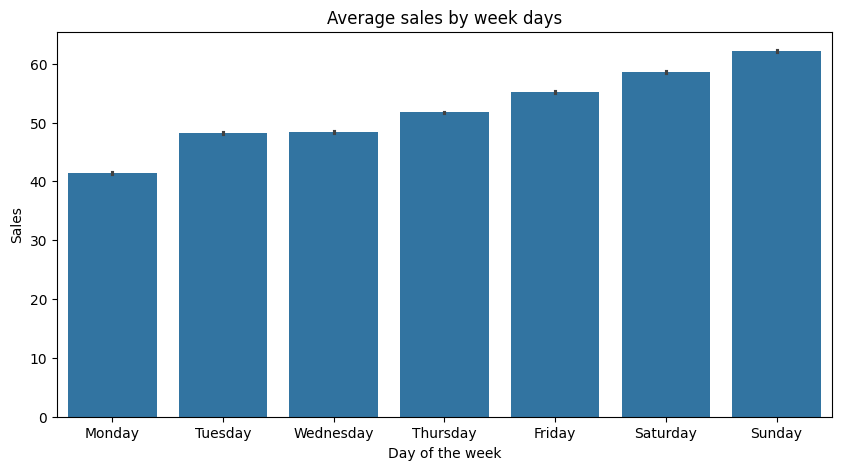

In [36]:
days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

plt.figure(figsize=(10,5))
ax = sns.barplot(x="day_of_week", y="sales", data=df)

ax.set_xticks(range(7))
ax.set_xticklabels(days_of_week)

plt.title("Average sales by week days")
plt.xlabel("Day of the week")
plt.ylabel("Sales")
plt.show();

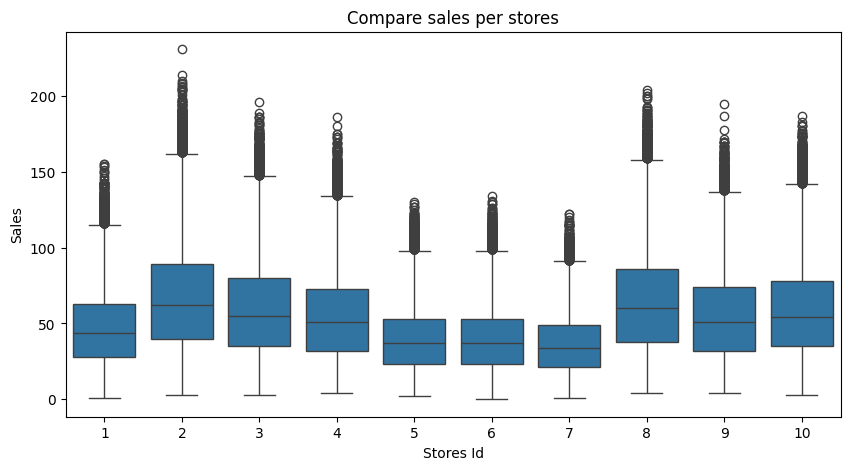

In [37]:
plt.figure(figsize=(10,5))
sns.boxplot(x="store", y="sales", data=df)
plt.title("Compare sales per stores")
plt.xlabel("Stores Id")
plt.ylabel("Sales")
plt.show()

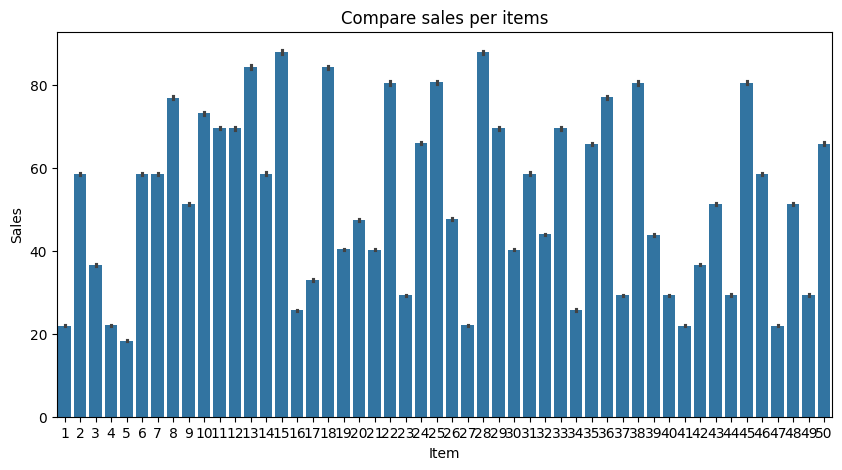

In [38]:
plt.figure(figsize=(10,5))
sns.barplot(x="item", y="sales", data=df)
plt.title("Compare sales per items")
plt.xlabel("Item")
plt.ylabel("Sales")
plt.show()

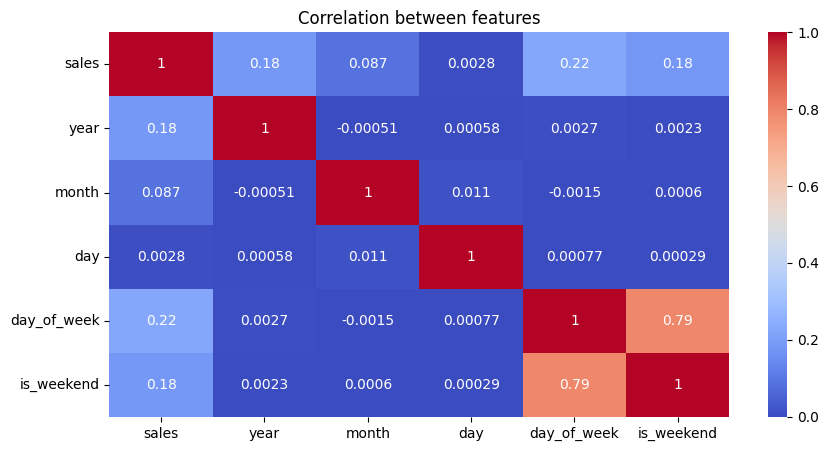

In [39]:
plt.figure(figsize=(10,5))
sns.heatmap(df[['sales', 'year', 'month', 'day', 'day_of_week', 'is_weekend']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation between features")
plt.show()

Based on the heatmap looks like there is no strong linear realashontiop between the features.

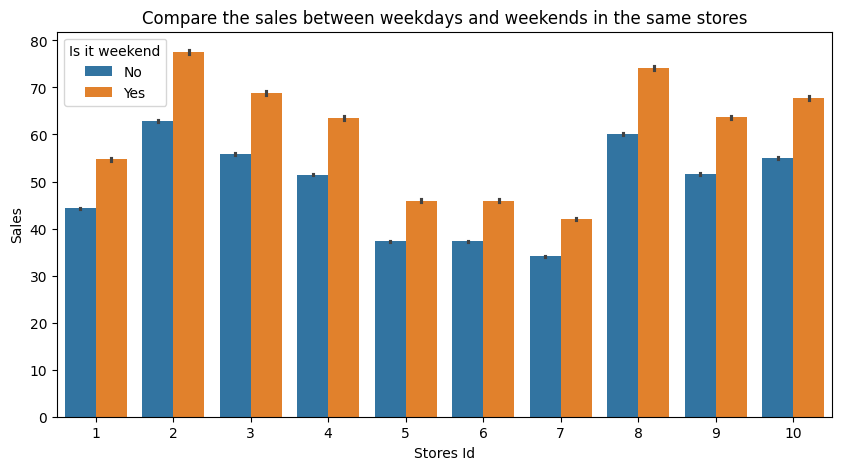

In [40]:
legend_label=["No", "Yes"]

plt.figure(figsize=(10,5))
ax = sns.barplot(x="store", y="sales", data=df, hue="is_weekend")

h, l = ax.get_legend_handles_labels()
ax.legend(h, legend_label, title="Is it weekend")

plt.title("Compare the sales between weekdays and weekends in the same stores")
plt.xlabel("Stores Id")
plt.ylabel("Sales")

plt.show()

Based on the barplot all the stores has a bigger sales numbers on the weekend

## Remove outliers before statistical test

In [41]:
# %%writefile data_processing.py

import pandas as pd

def remove_outliers_iqr(columns: list, data: pd.DataFrame) -> pd.DataFrame:
  """
    Removes outliers from the specified columns of a DataFrame using the IQR method.

    The function calculates the interquartile range (IQR) for the given columns and
    removes rows where values are outside the lower and upper bounds
    (Q1 - 1.5 * IQR and Q3 + 1.5 * IQR).

    Args:
        columns (list): List of column names from which outliers should be removed.
        df (pd.DataFrame): The DataFrame containing the data.

    Returns:
        pd.DataFrame: A new DataFrame with outliers removed from the specified columns.
    """
  Q1 = data[columns].quantile(0.25)
  Q3 = data[columns].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  mask = (data[columns] >= lower_bound) & (data[columns] <= upper_bound)
  return data[mask.all(axis=1)].copy()

In [42]:
df = remove_outliers_iqr(["sales"], df)

## Statistical test

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 901033 entries, 0 to 912999
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   date         901033 non-null  datetime64[ns]
 1   store        901033 non-null  int64         
 2   item         901033 non-null  int64         
 3   sales        901033 non-null  int64         
 4   year         901033 non-null  int32         
 5   month        901033 non-null  int32         
 6   day          901033 non-null  int32         
 7   day_of_week  901033 non-null  int32         
 8   is_weekend   901033 non-null  int64         
dtypes: datetime64[ns](1), int32(4), int64(4)
memory usage: 55.0 MB


In [44]:
from scipy.stats import kruskal
from scipy.stats import mannwhitneyu

df_lite = df[:160]

weekend = df_lite[df_lite['is_weekend']==1]['sales']
weekday = df_lite[df_lite['is_weekend']==0]['sales']

stat, p = mannwhitneyu(weekend, weekday)
print(f'U-stat: {stat}, p-value: {p:.5f}')
print("There is a significant difference between the sales on different week and on weekdays")

U-stat: 3594.5, p-value: 0.00024
There is a significant difference between the sales on different week and on weekdays


In [45]:
from scipy.stats import kruskal

h, p = kruskal(df_lite[df_lite['day_of_week']==0]['sales'],
               df_lite[df_lite['day_of_week']==1]['sales'],
               df_lite[df_lite['day_of_week']==2]['sales'],
               df_lite[df_lite['day_of_week']==3]['sales'],
               df_lite[df_lite['day_of_week']==4]['sales'],
               df_lite[df_lite['day_of_week']==5]['sales'],
               df_lite[df_lite['day_of_week']==6]['sales'],
)
print(f'H-stat: {h}, p-value: {p:.5f}')
print("There is a significant difference between the sales on different days")

H-stat: 23.106453269698545, p-value: 0.00076
There is a significant difference between the sales on different days


In [46]:
one_year_sales_df = df[df["year"] == 2017]

sales_by_month = [df[df['month']==m]['sales'] for m in range(1,13)]
h, p = kruskal(*sales_by_month)

print(f'H-statisztika: {h:.3f}, p-value: {p:.3f}')


H-statisztika: 85793.596, p-value: 0.000


## Conclusion
* On the weekend the sales numbers are bigger then on the weekend
* We can find a trend, on the summer the sales numbers are bigger then average